<span>
<img src="http://www.sobigdata.eu/sites/default/files/logo-SoBigData-DEFINITIVO.png" width="180px" align="right"/>
</span>
<span>
**Author:** Giulio Rossetti (giulio.rossetti@gmail.com)<br/>
**Python version:**  3.x<br/>
**Last update:** 22/01/2018
</span>

<a id='top'></a>

# *Titanic Case Study* 
The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this notebook, we will try to figure out what sorts of people were likely to survive. 

## Table of Contents
1. [Dataset Description](#dataset) 
2. [Data Cleaning](#cleaning) 
    1. [Missing Values](#mv)
    2. [Feature Engineering](#fe)
    3. [Feature Reshaping](#fr)
3. [Exploratory Analysis](#ea)
    1. [Features Distributions](#fd)
    2. [Dispersion and Outliers](#do)
    3. [Correlations](#cc)
4. [Regression](#pred)
    1. [Logistic Regression](#logit)
    2. [Evaluation](#eval)
    3. [Conclusions](#conclusions)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk # data mining tools
import matplotlib.pylab as plt # plotting
import seaborn as sns # advanced plotting
from pandas.tools.plotting import scatter_matrix
import warnings
warnings.filterwarnings("ignore")

<a id='dataset'></a>
## 1. Dataset description ([to top](#top))
As first step we load the whole Titanic Dataset and make confidence with its features...

In [2]:
titanic = pd.read_csv("data/titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Each record is described by 12 variables:

- The **Survived** variable is our outcome or dependent variable. It is a binary nominal datatype of 1 for survived and 0 for did not survive. All other variables are potential predictor or independent variables. It's important to note, more predictor variables do not make a better model, but the right variables.

- The **PassengerID** and **Ticket** variables are assumed to be random unique identifiers, that have no impact on the outcome variable. Thus, they will be excluded from analysis.

- The **Pclass** variable is an ordinal datatype for the ticket class, a proxy for socio-economic status (SES), representing 1 = upper class, 2 = middle class, and 3 = lower class.

- The **Name** variable is a nominal datatype. It could be used in feature engineering to derive the gender from title, family size from surname, and SES from titles like doctor or master. Since these variables already exist, we'll make use of it to see if title, like master, makes a difference.

- The **Sex** and **Embarked** variables are a nominal datatype. They will be converted to dummy variables for mathematical calculations.

- The **Age** and **Fare** variable are continuous quantitative datatypes.

- The **SibSp** represents number of related siblings/spouse aboard and **Parch** represents number of related parents/children aboard. Both are discrete quantitative datatypes. This can be used for feature engineering to create a family size and is alone variable.

- The **Cabin** variable is a nominal datatype that can be used in feature engineering for approximate position on ship when the incident occurred and SES from deck levels. However, since there are many null values, it does not add value and thus is excluded from analysis.

<a id='cleaning'></a>
## 2. Data Cleaning ([to top](#top))

In this stage, we will clean our data by 
 1. correcting aberrant values and outliers and completing missing information, 
 2. creating new features for analysis, and 
 3. converting fields to the correct format for calculations and presentation.

<a id='mv'></a>
### 2.A Missing Values ([to top](#top))
Reviewing the data, there does not appear to be any aberrant or non-acceptable data inputs.

Are there null values or missing data?

In [3]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
titanic.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Smith, Mr. Richard William",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [5]:
titanic['Age'].fillna(titanic['Age'].median(), inplace = True)
titanic['Embarked'].fillna(titanic['Embarked'].mode()[0], inplace = True)
titanic['Fare'].fillna(titanic['Fare'].median(), inplace = True)

In [6]:
drop_column = ['PassengerId','Cabin', 'Ticket']
titanic.drop(drop_column, axis=1, inplace = True)

In [7]:
titanic.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

<a id='fe'></a>
### 3.B Feature Engineering ([to top](#top))
Feature engineering is when we use existing features to create new features to determine if they provide new signals to predict our outcome. 

In order to better explicitate information hidden in the original data we engenier some new features

#### Creating discrete variables as combinations of existing ones

In [8]:
titanic['FamilySize'] = titanic ['SibSp'] + titanic['Parch'] + 1
titanic['IsAlone'] = 1 # initialize to yes/1 is alone
titanic['IsAlone'].loc[titanic['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

titanic[['FamilySize', 'IsAlone']].head()

,FamilySize,IsAlone
0,2,0
1,2,0
2,1,1
3,2,0
4,1,1


#### Binning continuos variable
In order to better analyze continuos variable we can transform them into discrete ones by binning.

Bins can be built either fixing frequency or bin size. 

In [9]:
titanic['FareBin'] = pd.qcut(titanic['Fare'], 4) # qcut: frequency bins
titanic['AgeBin'] = pd.cut(titanic['Age'].astype(int), 5) # cut: equal size value bins

titanic[['Fare', 'FareBin', 'Age', 'AgeBin']].head()

,Fare,FareBin,Age,AgeBin
0,7.2500,"(-0.001, 7.91]",22.0,"(16.0, 32.0]"
1,71.2833,"(31.0, 512.329]",38.0,"(32.0, 48.0]"
2,7.9250,"(7.91, 14.454]",26.0,"(16.0, 32.0]"
3,53.1000,"(31.0, 512.329]",35.0,"(32.0, 48.0]"
4,8.0500,"(7.91, 14.454]",35.0,"(32.0, 48.0]"


#### Transform Categorical (String) variables

In [10]:
# Identify title names (Mr. Miss. Mrs. etx)
# Split title from name

titanic['Title'] = titanic['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

titanic[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [11]:
# cleanup rare title names

stat_min = 10 
title_names = (titanic['Title'].value_counts() < stat_min) # create a true false series with title name as index
titanic['Title'] = titanic['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

titanic['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

<a id='fr'></a>
### 3.C Feature Reshaping ([to top](#top))

Last, but certainly not least, we'll deal with formatting. Our categorical data imported as objects, which makes it difficult for mathematical calculations. We will convert object datatypes to categorical dummy variables.

#### Convert categotical variables to numerical ones using Label Encoder

In [12]:
from sklearn.preprocessing import LabelEncoder

# encode labels with value between 0 and n_classes-1.
label = LabelEncoder()

titanic['Sex_Code'] = label.fit_transform(titanic['Sex'])
titanic['Embarked_Code'] = label.fit_transform(titanic['Embarked'])
titanic['Title_Code'] = label.fit_transform(titanic['Title'])
titanic['AgeBin_Code'] = label.fit_transform(titanic['AgeBin'])
titanic['FareBin_Code'] = label.fit_transform(titanic['FareBin'])

titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,FareBin,AgeBin,Title,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,"(-0.001, 7.91]","(16.0, 32.0]",Mr,1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs,0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,"(7.91, 14.454]","(16.0, 32.0]",Miss,0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs,0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,"(7.91, 14.454]","(32.0, 48.0]",Mr,1,2,3,2,1


<a id='ea'></a>
## 4. Exploratory Analysis ([to top](#top))
Now that our data is cleaned, we will explore our data with descriptive and graphical statistics to describe and summarize our variables. 

<a id='fd'></a>
### 4.A Features Distributions ([to top](#top))

In order to understand how the values of a continuos feature distribute we can use the kde (Kernel Density Estimate) plot

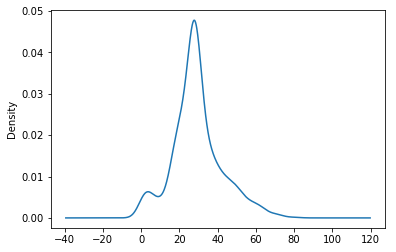

In [13]:
age = titanic['Age'].plot.kde()

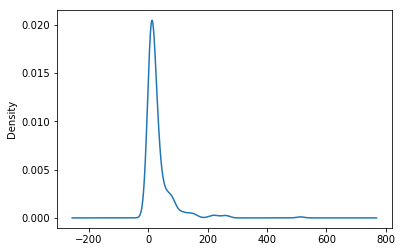

In [14]:
fare = titanic['Fare'].plot.kde()

#### Conditional Feature Distribution

We can build kde plots also by grouping values of a same feature w.r.t. a categorical variable.

For instance we can check if there are differences on the Age/Sex distributions of Survived/Dead passengers.

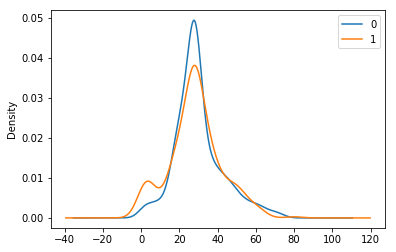

In [15]:
ax = titanic.groupby(['Survived']).Age.plot.kde()
plt.legend()
plt.show()

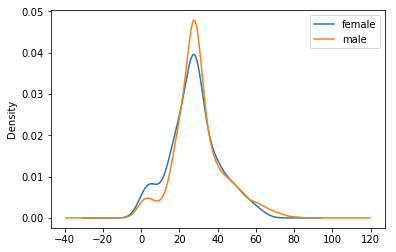

In [16]:
ax = titanic.groupby(['Sex']).Age.plot.kde()
plt.legend()
plt.show()

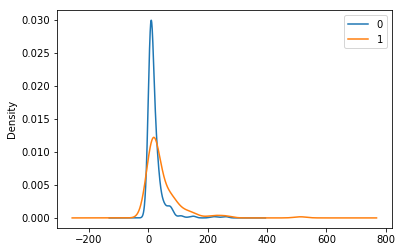

In [17]:
ax = titanic.groupby(['Survived']).Fare.plot.kde()
plt.legend()
plt.show()

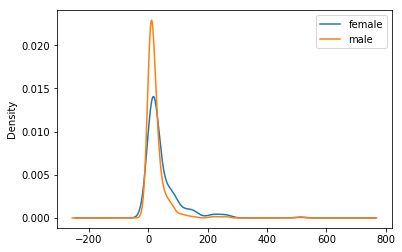

In [18]:
ax = titanic.groupby(['Sex']).Fare.plot.kde()
plt.legend()
plt.show()

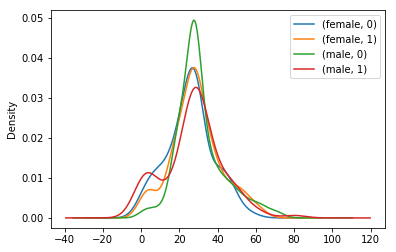

In [19]:
ax = titanic.groupby(['Sex', 'Survived']).Age.plot.kde()
plt.legend()
plt.show()

#### Histogram plot
We can also use Histograms instead of kde to capture binned class distribution.

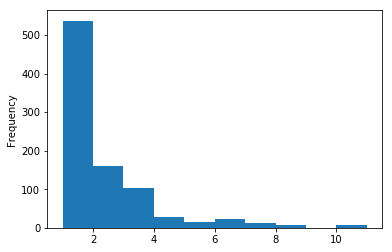

In [20]:
sx = titanic.FamilySize.plot.hist()

#### (Conditional, Stacked) histograms

In [21]:
def conditional_histogram(df, column):

    booldf1 = pd.DataFrame(titanic[titanic['Survived']==0][column])
    booldf1.columns = ['Dead']
    booldf2 = pd.DataFrame(titanic[titanic['Survived']==1][column])
    booldf2.columns = ['Survived']
    row_concat = pd.concat([booldf1, booldf2], axis=1)

    ax = row_concat.plot.hist(stacked=True, alpha=0.6)
    ax.set_xlabel(column)

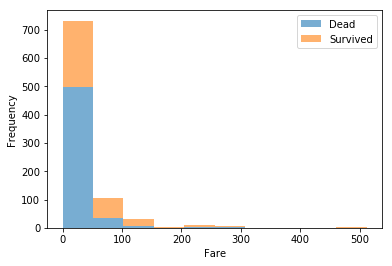

In [22]:
conditional_histogram(titanic, 'Fare')

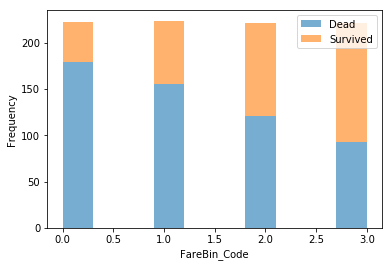

In [23]:
conditional_histogram(titanic, 'FareBin_Code')

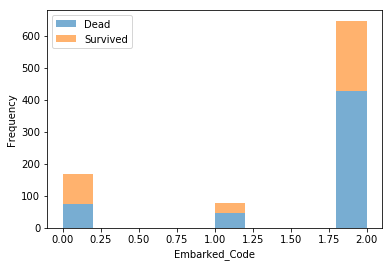

In [24]:
conditional_histogram(titanic, 'Embarked_Code')

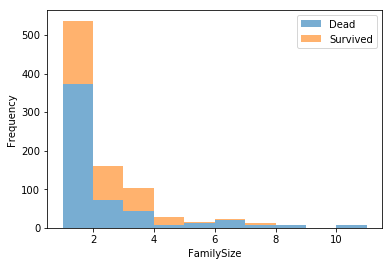

In [25]:
conditional_histogram(titanic, 'FamilySize')

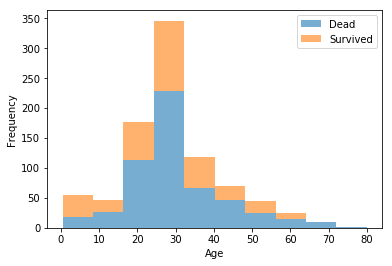

In [26]:
conditional_histogram(titanic, 'Age')

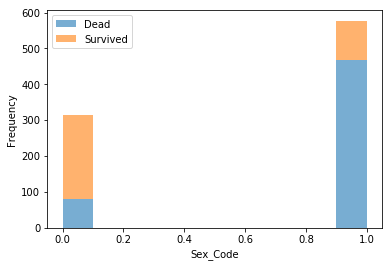

In [27]:
conditional_histogram(titanic, 'Sex_Code')

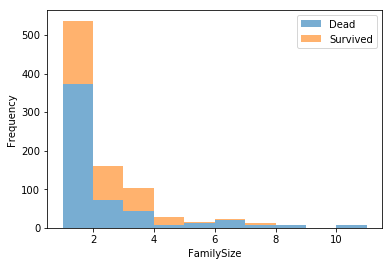

In [28]:
conditional_histogram(titanic, 'FamilySize')

#### Bar charts
Conversely from histograms (used to plot quantitative data with ranges of the data grouped into bins or intervals), bar charts plot categorical data.


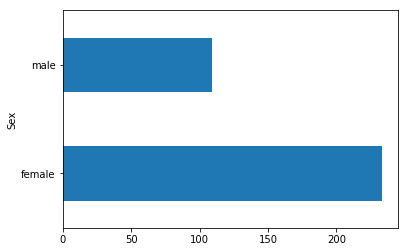

In [29]:
# Survived by sex

sx = titanic.groupby(['Sex']).Survived.sum().plot.barh()

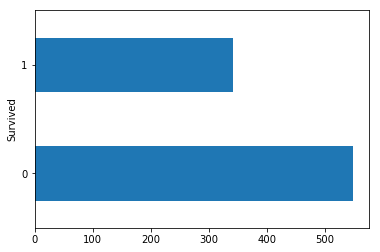

In [30]:
# Survived count

sx = titanic.groupby(['Survived']).Survived.count().plot.barh()

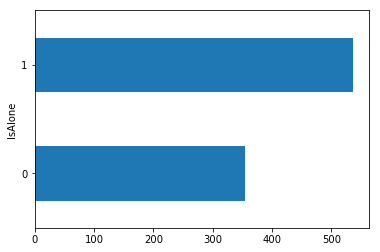

In [31]:
# Alone passengers

sx = titanic.groupby(['IsAlone']).IsAlone.count().plot.barh()

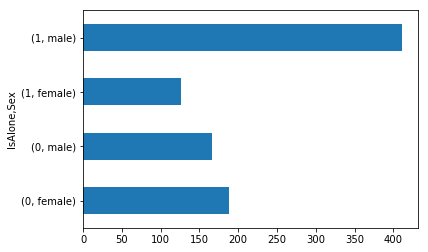

In [32]:
# Alone passangers grouped by sex

sx = titanic.groupby(['IsAlone', 'Sex']).IsAlone.count().plot.barh()

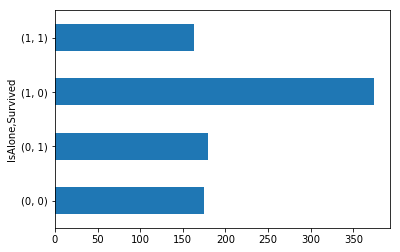

In [33]:
# Do being alone affect the survival rate?

sx = titanic.groupby(['IsAlone', 'Survived']).IsAlone.count().plot.barh()

#### (Conditional and Normalized) Bar plot

In [34]:
def conditional_bar_plot(df, columns, by):
    t1 = pd.DataFrame(df[columns].groupby(by).sum())
    t1.columns = ['Survived']
    t2 = pd.DataFrame(titanic[columns].groupby(by).count())
    t2.columns = ['Total']
    row_concat = pd.concat([t1, t2], axis=1)
    row_concat['Percentage'] = row_concat['Survived'] / row_concat['Total']
    return row_concat['Percentage'].plot.barh()

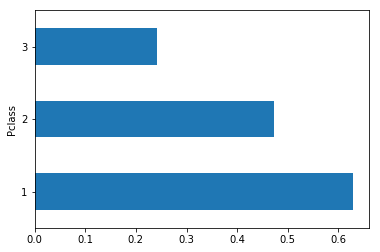

In [35]:
# Survival rate per Class

sp = conditional_bar_plot(titanic, ['Survived', 'Pclass'], ['Pclass'])

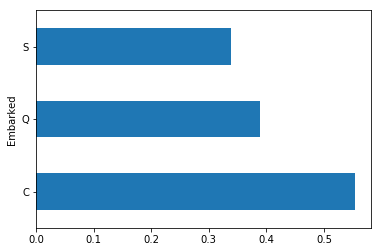

In [36]:
# Survival rate per Embarked

se = conditional_bar_plot(titanic, ['Survived', 'Embarked'], ['Embarked'])

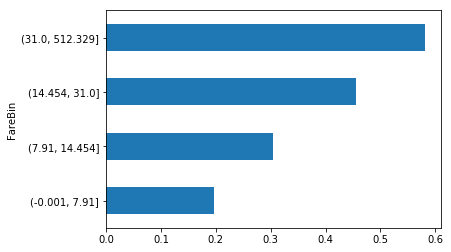

In [37]:
# Survival rate per Fare (binned)

sf = conditional_bar_plot(titanic, ['Survived', 'FareBin'], ['FareBin'])

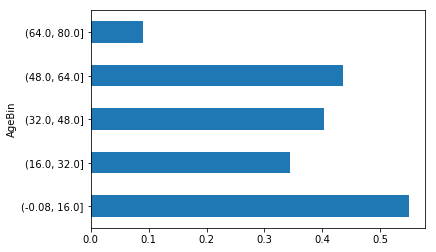

In [38]:
# Survival rate per Age (binned)

sa = conditional_bar_plot(titanic, ['Survived', 'AgeBin'], ['AgeBin'])

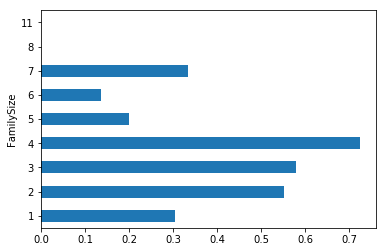

In [39]:
# Survival rate per Family Size

sf = conditional_bar_plot(titanic, ['Survived', 'FamilySize'], ['FamilySize'])

<a id='do'></a>
### 4.B Dispersion and Outliers ([to top](#top))

Box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles.

Box plots are non-parametric: they display variation in samples of a statistical population without making any assumptions of the underlying statistical distribution. The spacings between the different parts of the box indicate the degree of dispersion (spread) and skewness in the data, and show outliers.

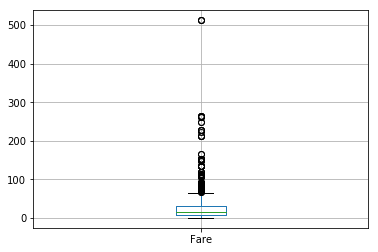

In [40]:
fare_box = titanic.boxplot(['Fare'], showfliers=True)

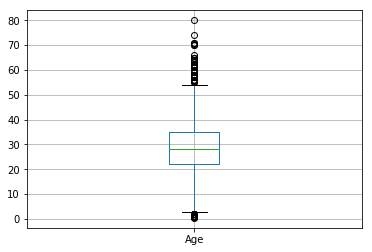

In [41]:
age_box = titanic.boxplot(['Age'], showfliers=True)

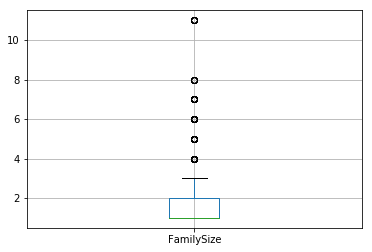

In [42]:
fs_box = titanic.boxplot(['FamilySize'], showfliers=True)

#### Conditional box plots

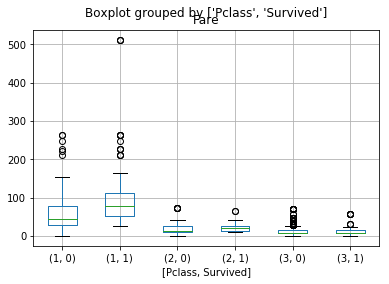

In [43]:
fare_by_cs = titanic.boxplot(['Fare'], by=['Pclass', 'Survived'])

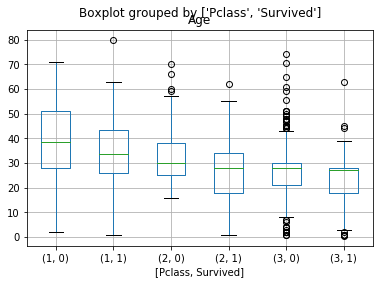

In [44]:
age_by_cs = titanic.boxplot(['Age'], by=['Pclass', 'Survived'])

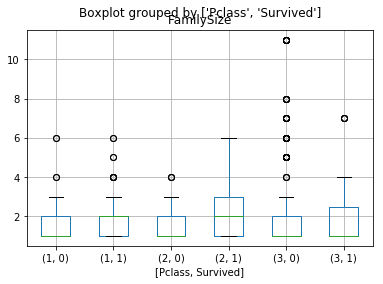

In [45]:
family_by_cs = titanic.boxplot(['FamilySize'], by=['Pclass', 'Survived'])

<a id='cc'></a>
### 3.C Correlations ([to top](#top))

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationships between two variables.

Several types of correlation coefficients exist, each with their own definition and own range of usability and characteristics. They have in common that they assume values in the range from −1 to +1, where +1 indicates the strongest possible agreement and −1 the strongest possible disagreement.

In [46]:
# Target label
Target = ['Survived']

titanic_1 = titanic[['Sex','Pclass', 'Embarked', 'Title', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Survived']]
titanic_1.head()

,Sex,Pclass,Embarked,Title,Age,Fare,FamilySize,IsAlone,Survived
0,male,3,S,Mr,22.0,7.2500,2,0,0
1,female,1,C,Mrs,38.0,71.2833,2,0,1
2,female,3,S,Miss,26.0,7.9250,1,1,1
3,female,1,S,Mrs,35.0,53.1000,2,0,1
4,male,3,S,Mr,35.0,8.0500,1,1,0


In [47]:
# Discrete Variable Correlation by Survival 

for x in titanic_1:
    if titanic_1[x].dtype != 'float64' and x!=Target[0]:
        print('\nSurvival Correlation by:', x)
        cor = titanic_1[[x, Target[0]]].groupby(x).mean()
        print(cor)


Survival Correlation by: Sex
        Survived
Sex             
female  0.742038
male    0.188908

Survival Correlation by: Pclass
        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

Survival Correlation by: Embarked
          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009

Survival Correlation by: Title
        Survived
Title           
Master  0.575000
Misc    0.444444
Miss    0.697802
Mr      0.156673
Mrs     0.792000

Survival Correlation by: FamilySize
            Survived
FamilySize          
1           0.303538
2           0.552795
3           0.578431
4           0.724138
5           0.200000
6           0.136364
7           0.333333
8           0.000000
11          0.000000

Survival Correlation by: IsAlone
         Survived
IsAlone          
0        0.505650
1        0.303538


We can observe that are more likely to survive:
 - Female passengers
 - 1st class passengers
 - C embarked
 - Those who are not alone
 - Those who have a FamilySize in [2, 4] 

#### Correlation matrix

The correlation matrix computes the correlation coefficients of the columns of a matrix. That is, row i and column j of the correlation matrix is the correlation between column i and column j of the original matrix. Note that the diagonal elements of the correlation matrix will be 1 (since they are the correlation of a column with itself). The correlation matrix is also symmetric since the correlation of column i with column j is the same as the correlation of column j with column i.

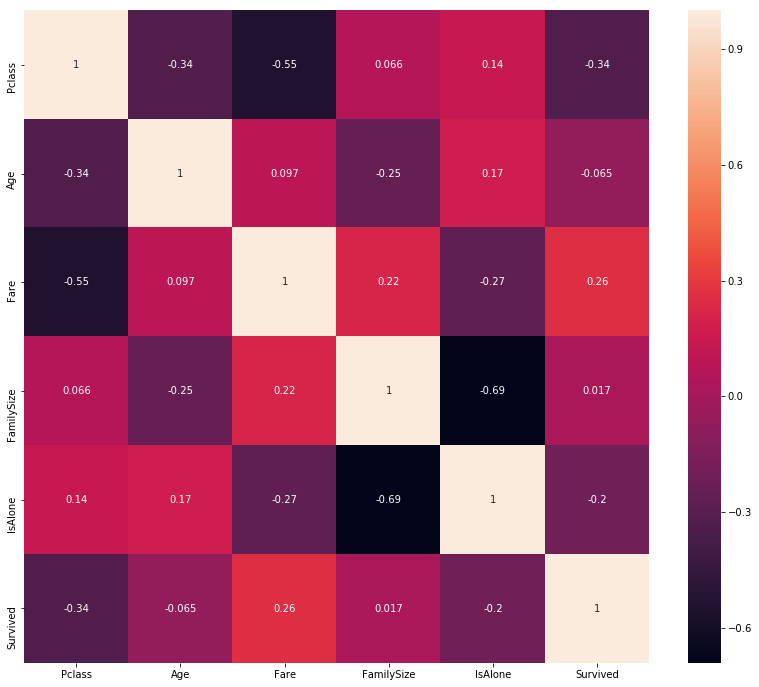

In [48]:
import seaborn as sns
corr = titanic_1.corr()
plt.subplots(figsize =(14, 12))
hm = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

#### Scatter plots

A scatter plot (also called a scatterplot, scatter graph, scatter chart, scattergram, or scatter diagram)[3] is a type of plot or mathematical diagram using Cartesian coordinates to display values for typically two variables for a set of data.

In [49]:
from pandas.plotting import scatter_matrix

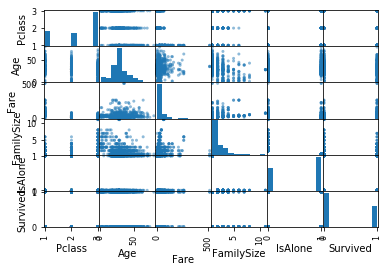

In [50]:
sm = scatter_matrix(titanic_1)

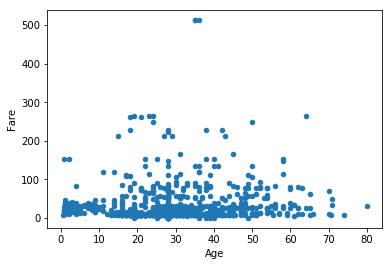

In [51]:
af = titanic.plot.scatter(x='Age', y='Fare')

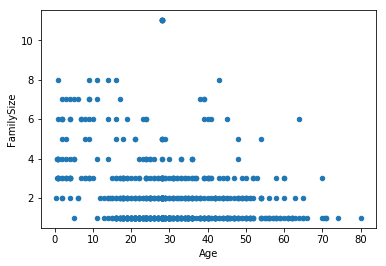

In [52]:
af = titanic.plot.scatter(x='Age', y='FamilySize')

<a id='pred'></a>
## 4. Regression ([to top](#top))

Regression is a data mining technique used to predict a range of numeric values (also called continuous values), given a particular dataset. Commonly, regression is used to predict a numeric or continuous value.

<a id='logit'></a>
### 4.A Logistic Regression ([to top](#top))

#### What is Logistic Regression?

Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary, as is 'Survived' in our case). 

Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

At the center of the logistic regression analysis is the task estimating the log odds of an event.

Mathematically, logistic regression estimates a multiple linear regression function defined as:

$$logit(p) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots \beta_n x_n $$

First we drop the target variable, 'survived', from the training set -- we store the target variable in its own dataframe. We also make a copy of the testing set

In [67]:
titanic_regression = titanic[['Survived', 'Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_Code']]

data = titanic_regression.drop("Survived",axis=1)
target = titanic_regression["Survived"]

Heavy lifting for logistic regression is done behind the scene by scikit-learn, a Python library. We take advantage of this abstractness. 

For validation purposes we split our data into **training set** (75%) and **test set** (25%).

In [68]:
from sklearn.cross_validation import train_test_split

In [69]:
x_train, x_holdout, y_train, y_holdout = train_test_split(data, target, test_size=0.25,  train_size=0.75)

Now we can:
1. **fit** the logistic regression model on the training set, and
2. **predict** the target on the test set

In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
# Model fitting

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
# Prediction

preds = logreg.predict(x_holdout)

Moreover, we can inspect the obtained model to capture feature relevance by looking at coefficient ($\beta$) weights

In [73]:
coeff_df = pd.DataFrame(titanic_regression.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

coeff_df

,Features,Coefficient Estimate
0,Pclass,-0.662402
1,Age,-0.019689
2,Fare,0.006661
3,FamilySize,-0.309796
4,IsAlone,-0.417538
5,Sex_Code,-2.542565


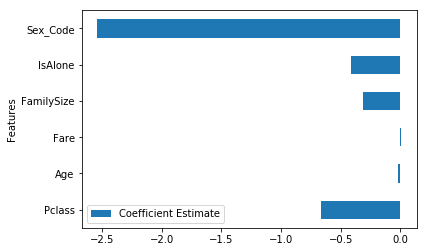

In [74]:
coeff_df.plot.barh(x='Features', y='Coefficient Estimate')

<a id='eval'></a>
### 4.B Evaluation ([to top](#top))

In order to evaluate the quality of prediction there exist several measures: all of them built upon the concept of **Confusion Matrix**.

#### Confusion Matrix

In the field of machine learning a confusion matrix is a specific table layout that allows visualization of the performance of an algorithm. 

Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa). 

Given a Target class (i.e. Survived):
- **True Positive (TP)** represent those instances correctly predicted to be True (i.e. we predict that a passenger will survive and it survived)
- **False Positive (FP)** represent those instances incorrectly predicted to be True (i.e. we predict that a passenger will survive and it did not)
- **True Negative (TN)** represent those instances correctly predicted to be False (i.e. we predict that a passenger will not survive and it not survived)
- **False Negative (FT)** represent those instances incorrectly predicted to be False (i.e. we predict that a passenger will not survive and, instead, it did survive)

Upon such classes are built several indicators.

In [75]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score

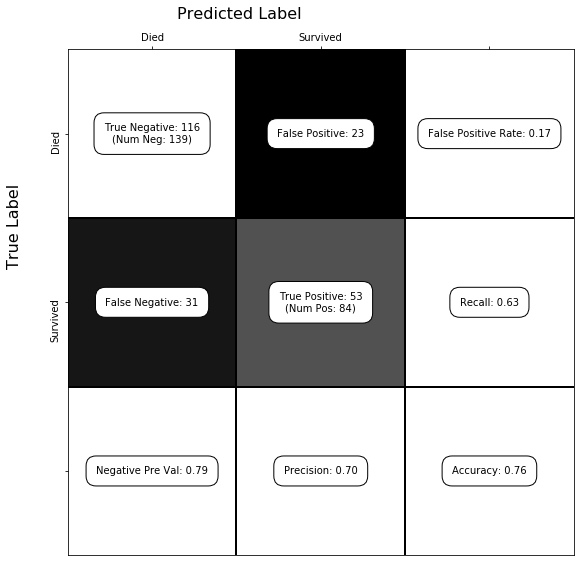

In [76]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Negative: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Negative: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Positive: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Positive: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Positive Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'Recall: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Negative Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Precision: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

c = confusion_matrix(y_holdout, logreg.predict(x_holdout))
show_confusion_matrix(c, ['Died', 'Survived'])

Among the otehrs, two scores characterize the outcome of a predictive model: *precision* and *recall* 

**Precision:** how many of the instances I predict to be True are really True?
$$precision = \frac{TP}{TP+FP}$$

**Recall:** how many True instances I was able to correctly predict?
$$recall = \frac{TP}{TP+FN}$$

To summarize the overall accuracy of a model we can also use the **F1-score**: it describes the armonic mean of *precision* and *recall*.

$$F1 = \frac{2TP}{2TP+FP+FN}$$

In [77]:
f1_score(y_holdout, preds)

0.66249999999999998

#### ROC curve

In statistics, a receiver operating characteristic curve, i.e. ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

The ROC curve is created by plotting the True Positive Rate (Precision) against the False Positive Rate at various threshold settings.

The higher the curve w.r.t. the baseline the better the prediction. The area under the ROC curve (AUCROC) can also be used to summarize ROC plots and compare differend models.

In [78]:
fpr, tpr, _ = roc_curve(y_holdout, preds)

In [79]:
roc_auc = roc_auc_score(y_holdout, preds)
roc_auc

0.73274237752655025

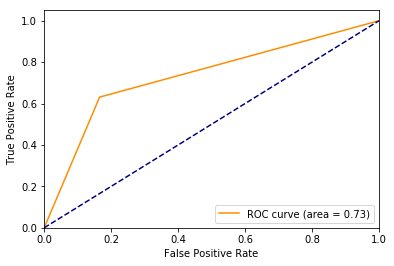

In [80]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

<a id='conclusions'></a>
### 4.C Conclusions ([to top](#top))

#### What did we do?
We used the survival titanic data to train a classifier (a logistic model) that predicts survival of a passenger given several features. To do so:

- We split the training data-set by 0.75-0.25 into training and holdout examples. 
- We performed dimensionality reduction by examining individual features and assessing how much impact they may have on the target variable. 
- We evaluated the performance of our model by printing out a confusion matrix obtained from the holdout data-set. 
- We printed out the f1-score.